In [ ]:
!pip install mtcnn

import tensorflow as tf
import keras
import os
import numpy as np
import math
import matplotlib.pyplot as plt
from mtcnn.mtcnn import MTCNN
from PIL import Image
import io
import requests
import tempfile
import collections

In [ ]:
# Used for getting the Raw data. Once you done that once and then saved the cleaned data to gcs you don't need to use this again.

# project_id = "data-science-projects-281712"
# from google.colab import auth
# auth.authenticate_user()

# !gcloud config set project {project_id}
# !mkdir /data
# !gsutil -m cp -r gs://rcv-mnm/data/raw/ /data/

In [1]:
# Globals
base_dir   = "/data/raw/"
clean_dir  = "/data/clean_faces2/"
IMAGE_SIZE = 224
TRAIN_BATCH_SIZE = 32
VALIDATION_BATCH_SIZE = 32

In [ ]:
#Method to extract Face
def extract_image_base(image):
    image = image.convert("RGB")          #convert the image to RGB format 
    pixels = np.asarray(image)              #convert the image to numpy array
    detector = MTCNN()                  #assign the MTCNN detector
    f = detector.detect_faces(pixels)
    #fetching the (x,y)co-ordinate and (width-->w, height-->h) of the image
    x1,y1,w,h = f[0]["box"]             
    x1, y1 = abs(x1), abs(y1)
    x2 = abs(x1+w)
    y2 = abs(y1+h)
    #locate the co-ordinates of face in the image
    store_face = pixels[y1:y2,x1:x2]
    image1 = Image.fromarray(store_face, "RGB")    #convert the numpy array to object
    image1 = image1.resize((IMAGE_SIZE, IMAGE_SIZE))             #resize the image
    return image1

# Gets image form a url
def get_url_image(img_url):
    buffer = tempfile.SpooledTemporaryFile(max_size=1e9)
    r = requests.get(img_url, stream=True)
    if r.status_code == 200:
        downloaded = 0
        filesize = int(r.headers["content-length"])
        for chunk in r.iter_content(chunk_size=1024):
            downloaded += len(chunk)
            buffer.write(chunk)
        buffer.seek(0)
        image = Image.open(io.BytesIO(buffer.read()))
    buffer.close()
    return image

# Loads an image from either a filepath or url.
def extract_image(
    input,
    input_type = "file",
):
    if input_type == "file":
        img1 = Image.open(input)
    elif input_type == "url":
        img1 = get_url_image(input)
    else:
        raise ValueError("Unsupported input type; must be 'file' or 'url'.")
    return extract_image_base(img1)

# Converts image into np.array to use for predictions.
def extract_image_to_nparray(
    input,
    input_type = "file",
):
    return np.expand_dims(np.asarray(extract_image(input, input_type)), axis=0)

# Cleans the data in the raw directory then saves it to gcp.

# for e in os.listdir(base_dir):
#     path = os.path.join(base_dir, e)
#     for x in os.listdir(path):
#         img = extract_image(os.path.join(path,x))
#         clean_path = os.path.join(clean_dir, e)
#         os.makedirs(clean_path, exist_ok = True)
#         clean_file = os.path.join(clean_path, x)
#         img.save(clean_file)
#         print(clean_file)

# import shutil

# for x in os.listdir(clean_dir):
#     clean_path = os.path.join(clean_dir, x)
#     file_count = len(os.listdir(clean_path))
#     if file_count < 15:
#         shutil.rmtree(clean_path)
#         print(file_count, clean_path)

# !gsutil -m cp -r /data/clean_faces/ gs://rcv-mnm/data/

In [6]:
# Authenticates my google user.
project_id = "data-science-projects-281712"
from google.colab import auth
auth.authenticate_user()

In [ ]:
# Loads the clean data from gcs.
!gcloud config set project {project_id}
!mkdir /data
!gsutil -m cp -r gs://rcv-mnm/data/clean_faces2/ /data/

In [ ]:
# Pre-processes the images like re-scaling and other required operations for the next steps.
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    brightness_range   = (0.80, 1.20),
    rotation_range     = 20,
    width_shift_range  = 0.1,
    height_shift_range = 0.1,
    fill_mode          = "nearest",
    rescale            = 1. / 255,
    validation_split   = 0.1,
    zoom_range         = 0.10,
)

# We separate out data set into Training and Validation.
# Create a train_generator
train_generator = data_generator.flow_from_directory(
    clean_dir,
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size  = TRAIN_BATCH_SIZE,
    subset      = "training",
    class_mode  = "categorical",
)

# Create a validation generator
val_generator = data_generator.flow_from_directory(
    clean_dir,
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size  = VALIDATION_BATCH_SIZE,
    subset      = "validation",
    class_mode  = "categorical",
)

# Triggers a training generator for all the batches
for image_batch, label_batch in train_generator:
    break

# This will print all classification labels in the console
print(train_generator.class_indices)

# Creating a file which will contain all names in the format of next lines
labels = '\n'.join(sorted(train_generator.class_indices.keys()))

# Writing it out to the file which will be named 'labels.txt'
with open('labels.txt', 'w') as f:
    f.write(labels)

Found 3761 images belonging to 10 classes.
Found 413 images belonging to 10 classes.
{'Aaron_Paul': 0, 'Alexander_Skarsgard': 1, 'Alexandra_Daddario': 2, 'Antonio_Banderas': 3, 'Benedict_Cumberbatch': 4, 'Blake_Lively': 5, 'Bruce_Dern': 6, 'Cary_Elwes': 7, 'Linus_Sebastian': 8, 'Robert_Beatty': 9}


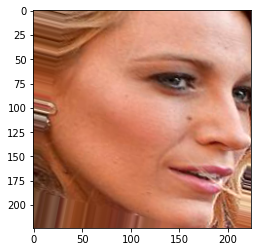

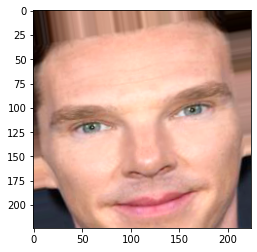

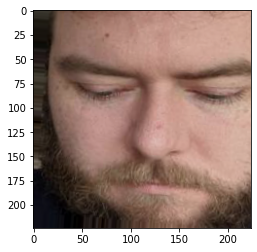

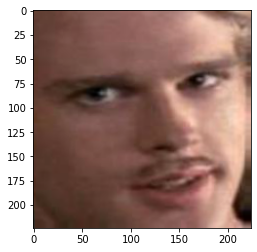

In [ ]:
# Prints a few examples of the validation data
x, y = val_generator.next()
for i in range(0, 4):
    image = x[i]
    plt.imshow(image)
    plt.show()

val_generator.reset()

In [ ]:
# To build our Facial Recognition model we are first going to use transfer learning.
# This involves train a top model while freezing the base model's (VGG16) weights.

# Resolution of images (Width , Height, Array of size 3 to accommodate RGB Colors)
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# VGG16 model pretrained on imagenet.
base_model = tf.keras.applications.VGG16(
    input_shape = IMG_SHAPE,
    include_top = False,
    weights = "imagenet",
)

# Freezes the VGG16 models weights.
base_model.trainable = False

# Checkpoints the model after an imporvement in the validation loss.
checkpoint = keras.callbacks.ModelCheckpoint(
    "latest_mnm_model.h5",
    monitor        = "val_loss",
    mode           = "min",
    save_best_only = True,
    verbose        = 1,
)

# Stops the model it fails to improve the validation loss after 10 epochs.
earlystop = keras.callbacks.EarlyStopping(
    monitor              = 'val_loss', 
    min_delta            = 0, 
    patience             = 10,
    verbose              = 1,
    restore_best_weights = True,
)

callbacks = [earlystop, checkpoint]

# Simple top model built upon the base model. It mostly takes the results of
# the base model and preps it for use in predicting via our dense layer.
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(train_generator.num_classes, activation="softmax"),
])

# Compiles the model. Required before you can do anything.
model.compile(
    optimizer = tf.keras.optimizers.Adam(),  # 1
    loss      = "categorical_crossentropy",  # 2
    metrics   = ["accuracy"], # 3
)  # 3

# To see the model summary in a tabular structure
model.summary()

# Train the model
epochs = 10000
history = model.fit(
    train_generator,
    epochs           = epochs,
    validation_data  = val_generator,
    callbacks        = callbacks,
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d_267 (Conv2D)         (None, 5, 5, 32)          147488    
                                                                 
 dropout_3 (Dropout)         (None, 5, 5, 32)          0         
                                                                 
 global_average_pooling2d_3   (None, 32)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_157 (Dense)           (None, 10)                330       
                                                                 
Total params: 14,862,506
Trainable params: 147,818
Non-trainable params: 14,714,688
____________________________________

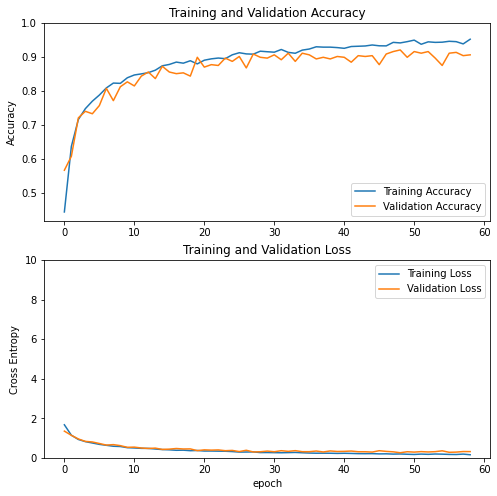

In [ ]:
# Training/validation accuracy and loss vs epoch plots
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()), 1])
plt.title("Training and Validation Accuracy")
plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.ylim([0, 10.0])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

In [ ]:
# Saving the Trained Model to the keras h5 format.
# So in future, if we want to convert again, we don"t have to go through the whole process.
saved_model_dir = "/data/models/latest_mnm_model.h5"
model.save(saved_model_dir)
print("Model Saved to /data/models/latest_mnm_model.h5")

!gsutil cp -r /data/models/latest_mnm_model.h5 gs://rcv-mnm/models/

In [ ]:
# Downloads the model so we can pick up from where we left off.
!gsutil cp -r gs://rcv-mnm/models/latest_mnm_model.h5 /data/models/latest_mnm_model.h5

model = tf.keras.models.load_model("/data/models/latest_mnm_model.h5")

In [ ]:
# In the first training phase we were only training a few layers on top of the base model. 
# The weights of the pre-trained network were NOT updated during training.
# To increse the performance even further we will train (fine-tune) the weights of the top layers
# of the pre-trained model alongside the training of the classifier you added.
# The training process will force the weights to be tuned from generic features maps to
# features associated specifically to our dataset.

# Unfreeze the base model.
base_model.trainable = True

# Everything from this point on is exactly the same except for the learning rate.
# Since the model should already be stable you want to use a small learning rate
# such that you are just fine tuning the weights and not changing them drastically.
# It should also be noted that we are using the model trained above.
checkpoint = keras.callbacks.ModelCheckpoint(
    "latest_finetuned_mnm_model.h5",
    monitor        = "val_loss",
    mode           = "min",
    save_best_only = True,
    verbose        = 1,
)

earlystop = keras.callbacks.EarlyStopping(
    monitor              = 'val_loss', 
    min_delta            = 0, 
    patience             = 10,
    verbose              = 1,
    restore_best_weights = True,
)

callbacks = [earlystop, checkpoint]

model.compile(
    loss      = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(1e-5),
    metrics   = ["accuracy"],
)

model.summary()

history_fine = model.fit(
    train_generator,
    epochs          = 10000,
    validation_data = val_generator,
    callbacks       = callbacks,
)

Number of layers in the base model:  19
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d_267 (Conv2D)         (None, 5, 5, 32)          147488    
                                                                 
 dropout_3 (Dropout)         (None, 5, 5, 32)          0         
                                                                 
 global_average_pooling2d_3   (None, 32)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_157 (Dense)           (None, 10)                330       
                                                                 
Total params: 14,862,506
Trainable params: 14,862,506
Non-trainable params: 0
__

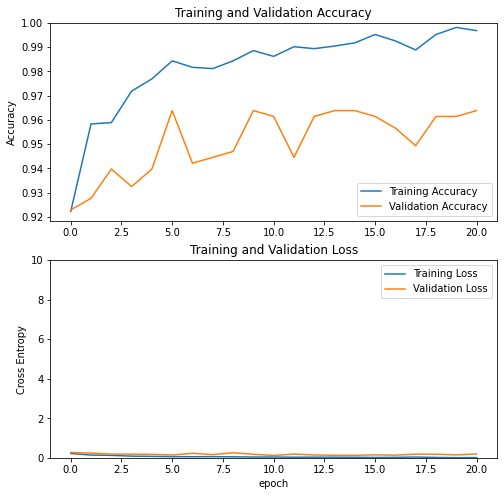

In [ ]:
# Training/validation accuracy and loss vs epoch plots
acc = history_fine.history["accuracy"]
val_acc = history_fine.history["val_accuracy"]
loss = history_fine.history["loss"]
val_loss = history_fine.history["val_loss"]
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()), 1])
plt.title("Training and Validation Accuracy")
plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.ylim([0, 10.0])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

In [ ]:
# Saving the Trained Model to the keras h5 format.
# So in future, if we want to convert again, we don"t have to go through the whole process.
saved_model_dir = "/data/models/latest_finetuned_mnm_model.h5"
model.save(saved_model_dir)
print("Model Saved to /data/models/latest_finetuned_mnm_model.h5")

!gsutil cp -r /data/models/latest_finetuned_mnm_model.h5 gs://rcv-mnm/models/

In [ ]:
# Downloads the model so we can pick up from where we left off.
!gsutil cp -r gs://rcv-mnm/models/latest_finetuned_mnm_model.h5 /data/models/latest_finetuned_mnm_model.h5

model = tf.keras.models.load_model("/data/models/latest_finetuned_mnm_model.h5")

In [ ]:
# Creates a reverse lookup table so we can get the name from the integer label.
labels_lookup = {value: key for key, value in train_generator.class_indices.items()}

labels_lookup

{0: 'Aaron_Paul',
 1: 'Alexander_Skarsgard',
 2: 'Alexandra_Daddario',
 3: 'Antonio_Banderas',
 4: 'Benedict_Cumberbatch',
 5: 'Blake_Lively',
 6: 'Bruce_Dern',
 7: 'Cary_Elwes',
 8: 'Linus_Sebastian',
 9: 'Robert_Beatty'}

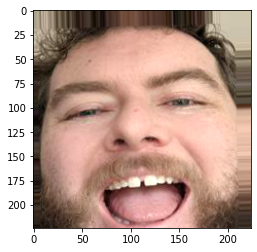

Predicted Person:  Linus_Sebastian
Actual Person:  Robert_Beatty , (Filepath:  /data/clean_faces/Robert_Beatty/PXL_20220101_191707599.MP.jpg )


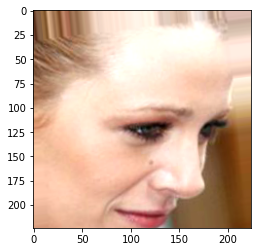

Predicted Person:  Alexander_Skarsgard
Actual Person:  Blake_Lively , (Filepath:  /data/clean_faces/Blake_Lively/108.jpg )


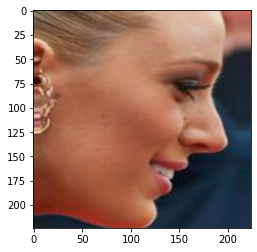

Predicted Person:  Alexander_Skarsgard
Actual Person:  Blake_Lively , (Filepath:  /data/clean_faces/Blake_Lively/145.jpg )


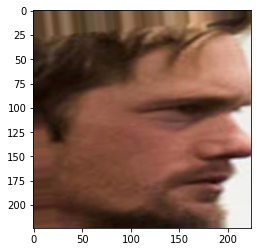

Predicted Person:  Cary_Elwes
Actual Person:  Alexander_Skarsgard , (Filepath:  /data/clean_faces/Alexander_Skarsgard/113.jpg )


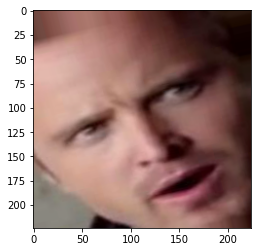

Predicted Person:  Cary_Elwes
Actual Person:  Aaron_Paul , (Filepath:  /data/clean_faces/Aaron_Paul/130.jpg )


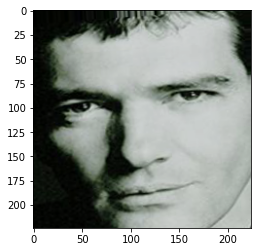

Predicted Person:  Benedict_Cumberbatch
Actual Person:  Antonio_Banderas , (Filepath:  /data/clean_faces/Antonio_Banderas/132.jpg )


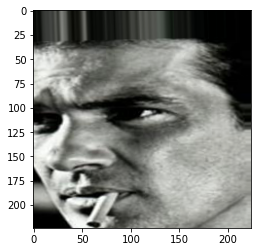

Predicted Person:  Benedict_Cumberbatch
Actual Person:  Antonio_Banderas , (Filepath:  /data/clean_faces/Antonio_Banderas/117.jpg )


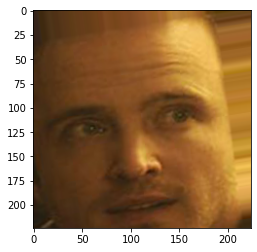

Predicted Person:  Bruce_Dern
Actual Person:  Aaron_Paul , (Filepath:  /data/clean_faces/Aaron_Paul/125.jpg )


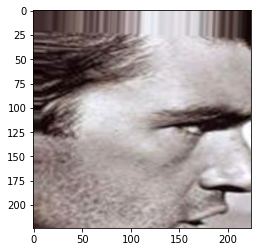

Predicted Person:  Alexander_Skarsgard
Actual Person:  Antonio_Banderas , (Filepath:  /data/clean_faces/Antonio_Banderas/101.jpg )


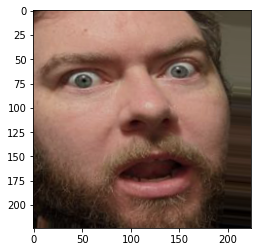

Predicted Person:  Linus_Sebastian
Actual Person:  Robert_Beatty , (Filepath:  /data/clean_faces/Robert_Beatty/PXL_20211230_165416789.MP.jpg )


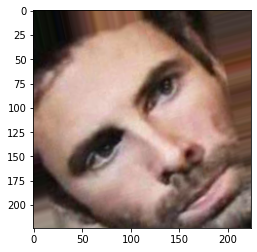

Predicted Person:  Alexandra_Daddario
Actual Person:  Bruce_Dern , (Filepath:  /data/clean_faces/Bruce_Dern/133.jpg )


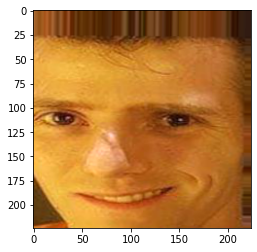

Predicted Person:  Bruce_Dern
Actual Person:  Linus_Sebastian , (Filepath:  /data/clean_faces/Linus_Sebastian/Image_18.jpg )


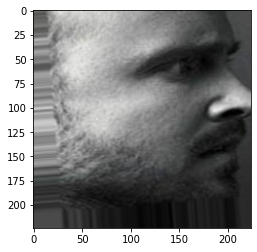

Predicted Person:  Bruce_Dern
Actual Person:  Aaron_Paul , (Filepath:  /data/clean_faces/Aaron_Paul/101.jpg )


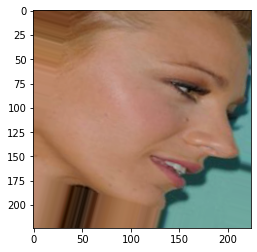

Predicted Person:  Alexander_Skarsgard
Actual Person:  Blake_Lively , (Filepath:  /data/clean_faces/Blake_Lively/109.jpg )


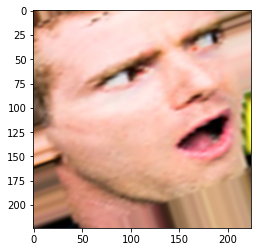

Predicted Person:  Benedict_Cumberbatch
Actual Person:  Linus_Sebastian , (Filepath:  /data/clean_faces/Linus_Sebastian/Image_20.png )


In [ ]:
# Outputs all of the misslabeled images in a full run of the validation generator.
val_generator.reset()
for j in range(0, math.ceil(val_generator.samples/VALIDATION_BATCH_SIZE)):
    x, y = val_generator.next()
    preds = model.predict(x).argmax(axis = 1)
    actuals = y.argmax(axis = 1)
    for i in range(0, len(x)):
        if preds[i] != actuals[i]:
            plt.imshow(x[i])
            plt.show()
            print("Predicted Person: ", labels_lookup[preds[i]])
            print("Actual Person: ", labels_lookup[actuals[i]], ", (Filepath: ", val_generator.filepaths[val_generator.index_array[j*VALIDATION_BATCH_SIZE + i]], ")")


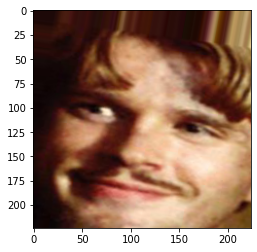

Predicted Person:  Benedict_Cumberbatch
Actual Person:  Cary_Elwes , (Filepath:  /data/clean_faces/Cary_Elwes/187.jpg )


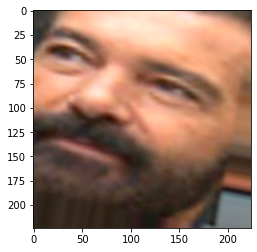

Predicted Person:  Alexandra_Daddario
Actual Person:  Antonio_Banderas , (Filepath:  /data/clean_faces/Antonio_Banderas/310.jpg )


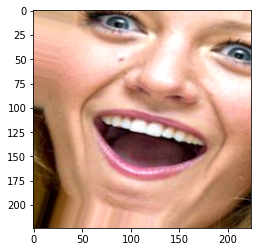

Predicted Person:  Alexandra_Daddario
Actual Person:  Blake_Lively , (Filepath:  /data/clean_faces/Blake_Lively/63.jpg )


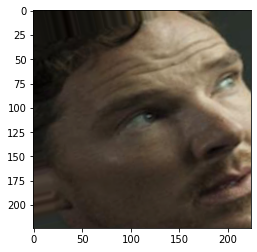

Predicted Person:  Bruce_Dern
Actual Person:  Benedict_Cumberbatch , (Filepath:  /data/clean_faces/Benedict_Cumberbatch/310.jpg )


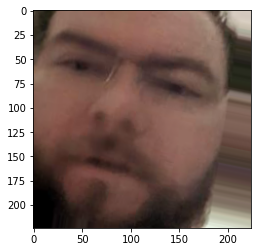

Predicted Person:  Blake_Lively
Actual Person:  Robert_Beatty , (Filepath:  /data/clean_faces/Robert_Beatty/PXL_20220103_151907389.jpg )


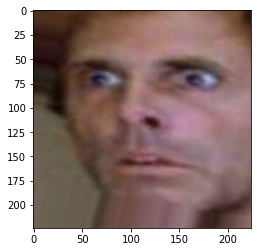

Predicted Person:  Alexander_Skarsgard
Actual Person:  Bruce_Dern , (Filepath:  /data/clean_faces/Bruce_Dern/384.jpg )


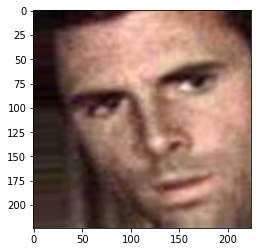

Predicted Person:  Alexandra_Daddario
Actual Person:  Bruce_Dern , (Filepath:  /data/clean_faces/Bruce_Dern/671.jpg )


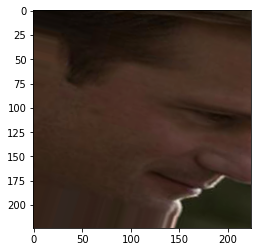

Predicted Person:  Cary_Elwes
Actual Person:  Alexander_Skarsgard , (Filepath:  /data/clean_faces/Alexander_Skarsgard/497.jpg )


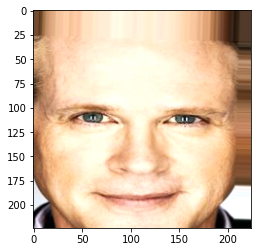

Predicted Person:  Alexander_Skarsgard
Actual Person:  Cary_Elwes , (Filepath:  /data/clean_faces/Cary_Elwes/6.jpg )


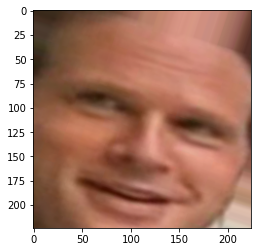

Predicted Person:  Alexander_Skarsgard
Actual Person:  Cary_Elwes , (Filepath:  /data/clean_faces/Cary_Elwes/367.jpg )


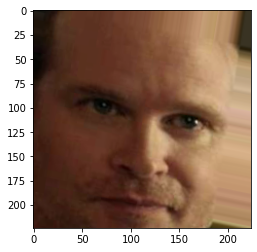

Predicted Person:  Alexander_Skarsgard
Actual Person:  Cary_Elwes , (Filepath:  /data/clean_faces/Cary_Elwes/17.jpg )


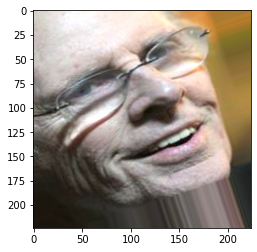

Predicted Person:  Benedict_Cumberbatch
Actual Person:  Bruce_Dern , (Filepath:  /data/clean_faces/Bruce_Dern/64.jpg )


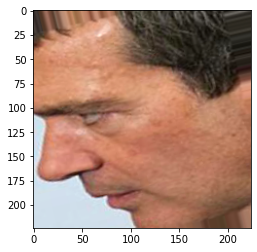

Predicted Person:  Benedict_Cumberbatch
Actual Person:  Antonio_Banderas , (Filepath:  /data/clean_faces/Antonio_Banderas/174.jpg )


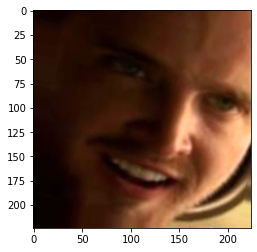

Predicted Person:  Alexander_Skarsgard
Actual Person:  Aaron_Paul , (Filepath:  /data/clean_faces/Aaron_Paul/762.jpg )


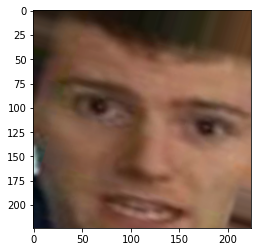

Predicted Person:  Alexandra_Daddario
Actual Person:  Linus_Sebastian , (Filepath:  /data/clean_faces/Linus_Sebastian/download (92).jpg )


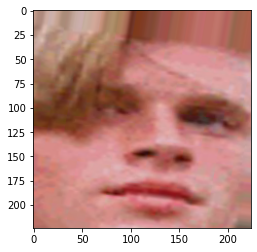

Predicted Person:  Bruce_Dern
Actual Person:  Cary_Elwes , (Filepath:  /data/clean_faces/Cary_Elwes/256.jpg )


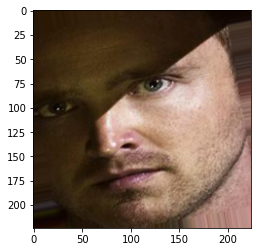

Predicted Person:  Alexander_Skarsgard
Actual Person:  Aaron_Paul , (Filepath:  /data/clean_faces/Aaron_Paul/616.jpg )


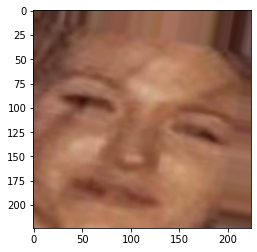

Predicted Person:  Alexandra_Daddario
Actual Person:  Blake_Lively , (Filepath:  /data/clean_faces/Blake_Lively/800.jpg )


In [ ]:
# Outputs all of the misslabeled images in a full run of the training generator.
train_generator.reset()
for j in range(0, math.ceil(train_generator.samples/VALIDATION_BATCH_SIZE)):
    x, y = train_generator.next()
    preds = model.predict(x).argmax(axis = 1)
    actuals = y.argmax(axis = 1)
    for i in range(0, len(x)):
        if preds[i] != actuals[i]:
            plt.imshow(x[i])
            plt.show()
            print("Predicted Person: ", labels_lookup[preds[i]])
            print("Actual Person: ", labels_lookup[actuals[i]], ", (Filepath: ", train_generator.filepaths[train_generator.index_array[j*VALIDATION_BATCH_SIZE + i]], ")")


In [ ]:
# Converts the model into a tf lite model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("/data/models/latest_finetuned_mnm_model.tflite", "wb") as f:
    f.write(tflite_model)

!gsutil cp -r /data/models/latest_finetuned_mnm_model.tflite gs://rcv-mnm/models/

In [ ]:
# Code for getting a random image from a bing search query.
from bs4 import BeautifulSoup
import json
import urllib
import random

def get_random_image_url(
    query: str,
):
    query = query.split()
    query = '+'.join(query) + "+face"
    url   = "https://www.bing.com/images/search?q=" + query + "&qft=+filterui:imagesize-large&FORM=R5IR3"

    #add the directory for your image here
    header={'User-Agent':"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/43.0.2357.134 Safari/537.36"}
    soup = BeautifulSoup(
        urllib.request.urlopen(
            urllib.request.Request(
                url,
                headers=header,
            )
        ),
        "html.parser"
    )

    ActualImages=[]
    for a in soup.find_all("a",{"class":"iusc"}):
        m = json.loads(a["m"])
        murl = m["murl"]
        ActualImages.append(murl)

    return random.choice(ActualImages)